# IBM Article Recommendation Engine

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


## <a class="anchor" id="Exploratory-Data-Analysis">Part I: Exploratory Data Analysis</a>

### User-Article Interaction (Articles per User)

In [4]:
usr_art = (
    df
    .groupby('email')['article_id']
    .count()
    .reset_index()
    .rename(columns={'article_id': 'num_articles'})
)
usr_art.head()

,email,num_articles
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


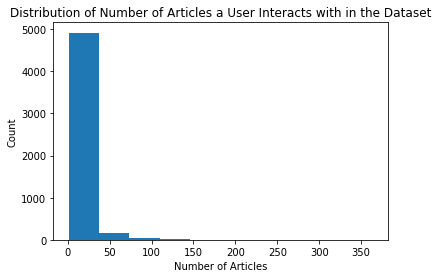

In [5]:
plt.hist(usr_art['num_articles'])
plt.title('Distribution of Number of Articles a User Interacts with in the Dataset')
plt.xlabel('Number of Articles')
plt.ylabel('Count')
plt.show;

In [6]:
min_val, max_val, mean_val, median_val, std_val = (
    usr_art['num_articles']
    .agg(['min', 'max', 'mean', 'median', 'std'])
    .round(decimals=2)
)
print('50% of individuals interact with {} articles or fewer.'.format(median_val))
print('On average, a user interacts with about {} articles.'.format(mean_val)) 
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_val))
print('The minimum number of user-article interactions by any 1 user is {}.'.format(min_val))

50% of individuals interact with 3.0 articles or fewer.
On average, a user interacts with about 8.93 articles.
The maximum number of user-article interactions by any 1 user is 364.0.
The minimum number of user-article interactions by any 1 user is 1.0.


### Article-User Interaction (Views per Article)

In [3]:
# remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

In [7]:
print('The number of unique articles that have at least one interaction:', df['article_id'].nunique())
print('The number of unique articles on the IBM platform:', df_content['article_id'].nunique())
print('The number of unique users:', df['email'].nunique()) 
print('The number of user-article interactions:', df.shape[0])

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


In [8]:
art_usr = (
    df
    .groupby('article_id')['email']
    .count()
    .reset_index()
    .rename(columns={'email': 'num_views'})
    .sort_values(by='num_views', ascending=False)
)
art_usr.head()

,article_id,num_views
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


In [9]:
print('The most viewed article in the dataset as a string with one value following the decimal:',
     art_usr.head(1)['article_id'].values[0])
print('The most viewed article in the dataset was viewed', art_usr.head(1)['num_views'].values[0], 'times.')

The most viewed article in the dataset as a string with one value following the decimal: 1429.0
The most viewed article in the dataset was viewed 937 times.


In [10]:
def email_mapper():
    """
    Map the user email to a user_id column and remove the email column.
    Note that there were a small number of null values, and it was found that all of these null values 
    likely belonged to a single user.
    """
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Since we don't actually have ratings for whether a user liked an article or not and we only know that a user has interacted with an article, the popularity of an article can only be based on how often an article was interacted with.

### Utility functions

In [33]:
def get_top_articles(n, df=df):
    """
    Return the n top articles ordered with most interactions as the top from df (not df_content)
     
    :param n: (int) the number of top articles to return
    :param df: (pandas dataframe) df as defined at the top of the notebook 
    :return: (list) a list of the top 'n' article titles 
    """
    top_articles = (
        df
        .groupby('title')['user_id']
        .count()
        .reset_index()
        .sort_values('user_id', ascending=False)
        .head(n)['title']
        .tolist()
    )
    return top_articles 


def get_top_article_ids(n, df=df):
    """
    Return the n top article ids ordered with most interactions as the top from df (not df_content)
    
    :param n: (int) the number of top articles to return
    :param df: (pandas dataframe) df as defined at the top of the notebook 
    :return: (list) a list of the top 'n' article titles 
    """
    top_articles = (
        df
        .groupby('article_id')['user_id']
        .count()
        .reset_index()
        .sort_values('user_id', ascending=False)
        .head(n)['article_id']
        .astype(str)
        .tolist()
    ) 
    return top_articles 

### Execution

In [12]:
print('Titles of Top 10 Articles:')
print(get_top_articles(10))
print()
print('IDs of Top 10 Articles:')
print(get_top_article_ids(10))

Titles of Top 10 Articles:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']

IDs of Top 10 Articles:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

### Utility functions

In [13]:
def create_user_item_matrix(df):
    """
    Create the user-article matrix with 1's and 0's
        - Each user should only appear in each row once.
        - Each article should only show up in one column.  
        - If a user has interacted with an article, then place a 1 where the user-row meets for that article-column.
        It does not matter how many times a user has interacted with the article, all entries where a user has 
        interacted with an article should be a 1.  
        - If a user has not interacted with an item, then place a 0 where the user-row meets for that article-column. 
        
    :param df: pandas dataframe with article_id, title, user_id columns
    :return: user-item matrix
    """
    user_item = (
        df[['article_id', 'user_id']]
        .drop_duplicates(keep='first')
        .assign(value=1)
        .pivot_table(index='user_id', columns='article_id', values='value', fill_value=0)
    )
    return user_item


def find_similar_users(user_id, user_item=user_item):
    """
    Compute the similarity of every pair of users based on the dot product (since results for each user are binary).
    The returned result should not contain the provided user_id, as we know that each user is similar to him/herself.
    
    :param user_id: (int) a user_id
    :param user_item: (pandas dataframe) matrix of users by articles with 1's 
                        when a user has interacted with an article and 0's otherwise
    :return: (pandas dataframe) a dataframe with:
                user_id - neighbor user_id
                similarity - measure of the similarity of each user to the provided user_id
    """
    usr_idx = user_item[user_item.index == user_id]
    dot_mat = usr_idx.dot(np.transpose(user_item))  # compute similarity by dot product

    most_similar_users_df = (
        dot_mat
        .reset_index(drop=True)
        .transpose()
        .rename(columns={0: 'similarity'})
        .sort_values(by='similarity', ascending=False)  # sort by similarity
        .query('user_id != @user_id')  # remove the own user's id
        .reset_index()
        .sort_values(by='similarity', ascending=False)
    )
    
    return most_similar_users_df


def find_similar_user_ids(user_id, user_item=user_item):
    """
    Return an ordered list of ids of the most similar users to that user (from most similar to least similar).  

    :param user_id: (int) a user_id
    :param user_item: (pandas dataframe) matrix of users by articles with 1 
                        when a user has interacted with an article and 0 otherwise
    :return: (list) an ordered list where the closest users (largest dot product users) are listed first
    """
    most_similar_df = find_similar_users(user_id, user_item)
    most_similar_ids = most_similar_df['user_id'].tolist()
    return most_similar_ids


def get_article_names(article_ids, df=df):
    """
    Return the article names associated with list of article ids
    
    :param article_ids: (list) a list of article ids
    :param df: (pandas dataframe) df as defined at the top of the notebook
    :return: (list) a list of article names associated with the list of article ids 
            (this is identified by the title column)
    """
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    return article_names


def get_user_articles(user_id, user_item=user_item):
    """
    Provide a list of article ids and article titles that have been seen by a user
    
    :param user_id: (int) a user id
    :param user_item: (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0's otherwise
    :return: (list) a list of the article ids seen by the user;
             (list) a list of article names associated with the list of article ids 
    """
    usr_row = user_item[(user_item.index == user_id)]
    article_ids = list(set(usr_row.columns[(usr_row == 1).iloc[0]].astype(str)))
    article_names = get_article_names(article_ids)
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    """
    Loop through the users based on their closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recommendations.
    Does this until m recommendations are found
    
    Notes: Users who are the same closeness are chosen arbitrarily as the 'next' user.
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily.
    
    :param user_id: (int) a user id
    :param m: (int) the number of recommendations you want for the user
    :return: (list) a list of recommendations for the user
    """   
    recs = []
    similar_users = find_similar_user_ids(user_id)
    seen_article_ids = get_user_articles(user_id)[0]
    
    for usr in similar_users:
        other_articles = get_user_articles(usr)[0]
        for x in other_articles:
            if x not in seen_article_ids and x not in recs and len(recs) < 10:
                recs.append(x)
            
    return recs


def get_top_sorted_users(user_id, df=df, user_item=user_item):
    """
    Return users who are most similar to the supplied user id in descending order of similarity 
    and number of interactions.
    
    :parm user_id: (int) a user id
    :param df: (pandas dataframe) df as defined at the top of the notebook 
    :param user_item: (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0's otherwise
    :return: (pandas dataframe) a dataframe with:
                neighbor_id - is a neighbor user_id
                similarity - measure of the similarity of each user to the provided user_id
                num_interactions - the number of articles viewed by the user 
    """
    user_interactions = (
        df
        .groupby('user_id')['article_id']
        .count()
        .reset_index()
        .rename(columns={'article_id': 'num_interactions'})
        .sort_values(by='num_interactions', ascending=False)
    )
    similar_users = find_similar_users(user_id, user_item)
    neighbors_df = (
        pd.merge(similar_users, user_interactions, how='left', on='user_id')
        .sort_values(by=['similarity', 'num_interactions'], ascending=False)
    )
    return neighbors_df


def user_user_recs_part2(user_id, df=df, m=10):
    """
    Loop through the users based on closeness to the input user_id.
    For each user - find articles the user hasn't seen before and provides them as recs.
    Do this until m recommendations are found.
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    
    :param user_id: (int) a user id
    :param m: (int) the number of recommendations you want for the user
    
    :return: (list) a list of recommendations for the user by article id
    :return: (list) a list of recommendations for the user by article title
    """
    recs = []
    similar_users = get_top_sorted_users(user_id)['user_id']
    seen_article_ids = get_user_articles(user_id)[0]

    for usr in similar_users:
        other_articles = get_user_articles(usr)[0]
        sorted_other_articles = (
            df
            .query('article_id in @other_articles', engine='python')
            .groupby('article_id')['user_id']
            .count()
            .reset_index()
            .rename(columns={'user_id': 'num_views'})
            .sort_values('num_views', ascending=False)
        )
        for x in sorted_other_articles['article_id']:
            if x not in seen_article_ids and x not in recs and len(recs) < 10:
                recs.append(x)
        rec_names = get_article_names(recs)
    
    return recs, rec_names

### Execution

In [14]:
user_item = create_user_item_matrix(df)
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
print('The 10 most similar users to user 1 are: {}'.format(find_similar_user_ids(1)[:10]))
print('The 5 most similar users to user 3933 are: {}'.format(find_similar_user_ids(3933)[:5]))
print('The 3 most similar users to user 46 are: {}'.format(find_similar_user_ids(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [39]:
print('10 recommendations for user 1:')
print()
print(get_article_names(user_user_recs(1, 10))) 

10 recommendations for user 1:

['520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object', 'movie recommender system with spark machine learning', 'pixiedust gets its first community-driven feature in 1.0.4', 'flightpredict ii: the sequel  – ibm watson data lab', 'this week in data science (may 2, 2017)', 'using rstudio in ibm data science experience', 'ml algorithm != learning machine', 'airbnb data for analytics: vancouver listings', 'pixiedust 1.0 is here! – ibm watson data lab', 'analyze accident reports on amazon emr spark']


In [22]:
rec_ids, rec_names = user_user_recs_part2(20, df, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['gosales transactions for logistic regression model', 'movie recommender system with spark machine learning', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'model bike sharing data with spss', 'insights from new york car accident reports', 'analyze accident reports on amazon emr spark']


In [43]:
user1_most_sim = get_top_sorted_users(1)['user_id'][0]  
user131_10th_sim = get_top_sorted_users(131)['user_id'][9]  

print('The user that is most similar to user 1:', user1_most_sim)
print('The 10th most similar user to user 131:', user131_10th_sim)

The user that is most similar to user 1: 3933
The 10th most similar user to user 131: 242


The cold start problem: for a new user, it's impossible to use collaborative filtering methods to make recommendation since we don't have any data on them. Methods like rank-based and content-based recommenders are the only way to get started with making recommendations for these individuals. 

In [37]:
# as a new user, they have no observed articles, so we'd recommend the most popular articles
new_user = '0.0'
new_user_recs = get_top_article_ids(10) 

In the following section, we will work on building a content-based recommender which could also help these new users out. 

### Tests

In [40]:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print('Tests for creating user-item interaction matrices passed!')

Tests for creating user-item interaction matrices passed!


In [41]:
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! get_article_names() doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! get_article_names() function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print('Tests for extracting article ids and article names passed!')

Tests for extracting article ids and article names passed!


In [42]:
assert user1_most_sim == 3933, "Oops! get_top_sorted_users() function doesn't work quite how we expect."
assert user131_10th_sim == 242, "Oops! get_top_sorted_users() function doesn't work quite how we expect."
print('Tests for returning most similar users in a sorted order passed!')

Tests for returning most similar users in a sorted order passed!


In [44]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
print('Test for returning recommendations for new user passed!')

Test for returning recommendations for new user passed!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In [45]:
# this is the user-item matrix we created in Part III
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [46]:
u, s, vt = np.linalg.svd(user_item)  # perform SVD on the user-item matrix

In [53]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

As the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

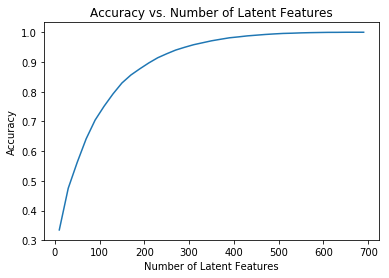

In [55]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

In [62]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
   
    return user_item_train, user_item_test

user_item_train, user_item_test = create_test_and_train_user_item(df_train, df_test)

In [83]:
train_ids = set(df_train['user_id'])
test_ids = set(df_test['user_id'])

train_arts = set(df_train['article_id']) 
test_arts = set(df_test['article_id'])

not_in_train_ids = len(test_ids - train_ids)
in_train_ids = len(test_ids.intersection(train_ids))

not_in_train_arts = len(test_arts - train_arts)
in_train_arts = len(test_arts.intersection(train_arts))

574


In [86]:
print('Number of users we can make predictions for in the test set:', in_train_ids)
print('Number of users we are not able to make predictions for because of the cold start problem:', not_in_train_ids)
print('Number of articles we can make predictions for in the test set:', in_train_arts)
print('Number of articles we are not able to make predictions for because of the cold start problem:', not_in_train_arts)

Number of users we can make predictions for in the test set: 20
Number of users we are not able to make predictions for because of the cold start problem: 662
Number of articles we can make predictions for in the test set: 574
Number of articles we are not able to make predictions for because of the cold start problem: 0


All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [87]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [89]:
user_item_test_subset = user_item_test[user_item_test.index.isin(user_item_train.index)]

In [101]:
idx = np.where(user_item_train.index.isin(user_item_test.index))[0]

20

In [92]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_est_subset)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

AttributeError: 'numpy.ndarray' object has no attribute 'index'

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])